In [1]:
# pip install
#!pip install -r requirements.txt
#!pip install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.size'] = 18
import numpy as np
import pandas as pd
from pprint import pprint

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


In [2]:
# Open data file
file_dir = "./assets/FTFP/A_Z_vol_count-all.txt"
columns = ["Mass Number", "Atomic Number", "Detector Volume", "Counts"]
df = open_data(file_dir, columns)

In [3]:
# Add in isotope data
add_isotope_data(df)
# Reorder columns
df = df[["Iso Symbol","Atomic Number","Mass Number","Counts", "Detector Volume","Production Yield","Stable","Half Life (ns)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

# Add Production (/yr)

In [4]:
# Simulation length = years * nanoseconds
year_in_nano = (3.154 * 10**16)
year_in_sec = (3.154 * 10**7)
sim_length = 29.01
df["Production (/yr)"] = df["Counts"] / sim_length

# Add count per muon

In [5]:
# number of muons per year
muon_no = (3.447 * 10**6)
df["Count per Muon"] = df["Production (/yr)"] / muon_no
# Normalise
df["Count per Muon"] = (df["Count per Muon"] - df["Count per Muon"].min()) / (df["Count per Muon"].max() - df["Count per Muon"].min())

# Clean unstable isotopes into two datasets

In [6]:
df_unstable = df[df["Stable"] == False]
df_unstable = df_unstable.reset_index()
df_stable = df[df["Stable"] == True]
df_stable = df_stable.reset_index()
print(f"Number of stable isotopes: {len(df) - len(df_unstable)}")
print(f"Number of unstable isotopes: {len(df_unstable)}")
#df_unstable, df_stable

Number of stable isotopes: 126
Number of unstable isotopes: 402


In [7]:
# Data analysis
print(f"Total average production yield per muon: {round(df['Count per Muon'].mean(), 5)}")
print(f"Unstable average production yield per muon: {round(df_unstable['Count per Muon'].mean(), 5)}")
print(f"Stable average production yield per muon: {round(df_stable['Count per Muon'].mean(), 5)}")

Total average production yield per muon: 0.00478
Unstable average production yield per muon: 0.00024
Stable average production yield per muon: 0.01929


# Plot All

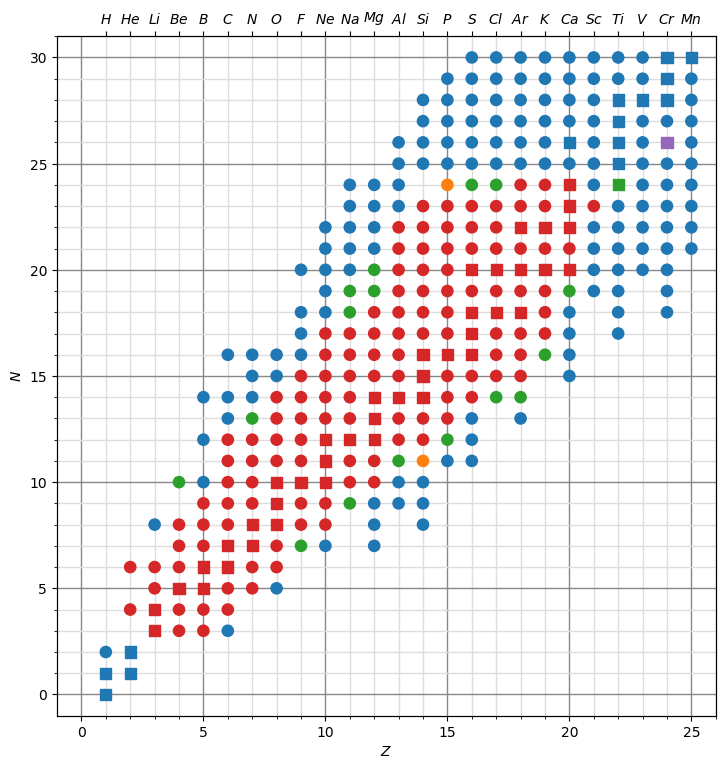

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import ticker
PTS_PER_INCH = 72

df_plot = df

element_symbols = [
 'H', 'He', 'Li', 'Be',  'B',  'C',  'N',  'O',  'F', 'Ne', 'Na', 'Mg', 'Al',
'Si',  'P',  'S', 'Cl', 'Ar',  'K', 'Ca', 'Sc', 'Ti',  'V', 'Cr', 'Mn', 'Fe',
'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',  'Y',
'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',  'W', 'Re', 'Os', 'Ir', 'Pt',
'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa',
 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf',
'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts',
'Og'
]

def get_marker_size(ax, nx, ny):
    """Determine the appropriate marker size (in points-squared) for ax."""

    # Get Axes width and height in pixels.
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    # Spacing between scatter point centres along the narrowest dimension.
    spacing = min(width, height) * PTS_PER_INCH / min(nx, ny)
    # Desired radius of scatter points.
    rref =  spacing / 2 * 0.5
    # Initial scatter point size (area) in pt^2.
    s = np.pi * rref**2
    return s

isotopes_stable = {}
isotopes_unstable = {}
for line in open('isotopes.txt'):
    line = line.rstrip()
    halflife = line[10:]
    if halflife == 'None':
        continue
    fields = line[:10].split('-')
    symbol = fields[0]
    A = int(fields[1].split()[0])
    Z = int(element_symbols.index(symbol)) + 1
    N = A - Z
    halflife = float(halflife)
    if Z < 26 and N < 31:
        checkTPC = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & (df_plot["Detector Volume"] == 11)]
        checkBUFFERS = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & ((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9))]
        checkELSE = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & ~((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9) | (df_plot["Detector Volume"] == 11))]
        # if stable
        if halflife >= 0:
            # if in both - red
            if not checkTPC.empty and not checkBUFFERS.empty:
                isotopes_stable[(N, Z)] = np.array([214, 39, 40]) / 255
            # If in TPC - orange
            elif not checkTPC.empty:
                isotopes_stable[(N, Z)] = np.array([255, 127, 14]) / 255
            # If in buffers - green
            elif not checkBUFFERS.empty:
                isotopes_stable[(N, Z)] = np.array([44, 160, 44]) / 255
            # If in elsewhere - purple
            elif not checkELSE.empty:
                isotopes_unstable[(N, Z)] = np.array([148, 103, 189]) / 255
            # Else blue
            else:
                isotopes_stable[(N, Z)] = np.array([31, 119, 180]) / 255
        # if unstable
        else:
            # if in both - red
            if not checkTPC.empty and not checkBUFFERS.empty:
                isotopes_unstable[(N, Z)] = np.array([214, 39, 40]) / 255
            # If in TPC - orange
            elif not checkTPC.empty:
                isotopes_unstable[(N, Z)] = np.array([255, 127, 14]) / 255
             # If in buffers - green
            elif not checkBUFFERS.empty:
                isotopes_unstable[(N, Z)] = np.array([44, 160, 44]) / 255
            # If in elsewhere - purple
            elif not checkELSE.empty:
                isotopes_unstable[(N, Z)] = np.array([148, 103, 189]) / 255
            # Else blue
            else:
                isotopes_unstable[(N, Z)] = np.array([31, 119, 180]) / 255

# Unwrap the isotopes dictionary into sequences of N, Z, thalf; take the log.
k_s, colors_s = zip(*isotopes_stable.items())
N_s, Z_s = zip(*k_s)
k_u, colors_u = zip(*isotopes_unstable.items())
N_u, Z_u = zip(*k_u)
maxN, maxZ = max(max(N_s), max(N_u)) + 1, max(max(Z_s), max(Z_u)) + 1
# Initial dimensions of the plot (pixels); figure resolution (dots-per-inch).
w, h = 850, 900
DPI = 100
w_in, h_in = w / DPI, h / DPI
# Set up the figure: one Axes object for the plot, another for the colourbar.
fig, ax = plt.subplots(figsize=(w_in, h_in), dpi=DPI)

s = get_marker_size(ax, maxZ, maxN)
sc1 = ax.scatter(Z_s, N_s, c=colors_s, s=s, marker="o")
sc1 = ax.scatter(Z_u, N_u, c=colors_u, s=s, marker="s")

# Jump through the usual hoops to get a grid on both major and minor ticks
# under the data.
loc = ticker.MultipleLocator(base=5)
ax.xaxis.set_minor_locator(loc)
ax.yaxis.set_minor_locator(loc)
ax.grid(which='major', color='#888888', lw=1)
ax.grid(which='minor', color='#dddddd', lw=1)
plt.minorticks_on()
ax.set_axisbelow(True)

ax.set_xlim(-1, maxZ)
ax.set_ylim(-1, maxN)
ax.set_xlabel(r'$Z$')
ax.set_ylabel(r'$N$')
# Twin the y-axis to indicate the noble gas elements on the top x-axis.
topax = ax.twiny()
topax.set_xticks(np.linspace(1, 25, 25))
topax.set_xticklabels([r'$H$', r'$He$', r'$Li$', r'$Be$',  r'$B$',  r'$C$',  r'$N$',  r'$O$',  r'$F$', r'$Ne$', r'$Na$', r'$Mg$', r'$Al$',
r'$Si$',  r'$P$',  r'$S$', r'$Cl$', r'$Ar$',  r'$K$', r'$Ca$', r'$Sc$', r'$Ti$',  r'$V$', r'$Cr$', r'$Mn$'])
topax.set_xlim(-1, maxZ)
plt.savefig('./img/nuclides-chart.png', dpi=DPI)
plt.show()
# Need to get legend https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#automated-legend-creation

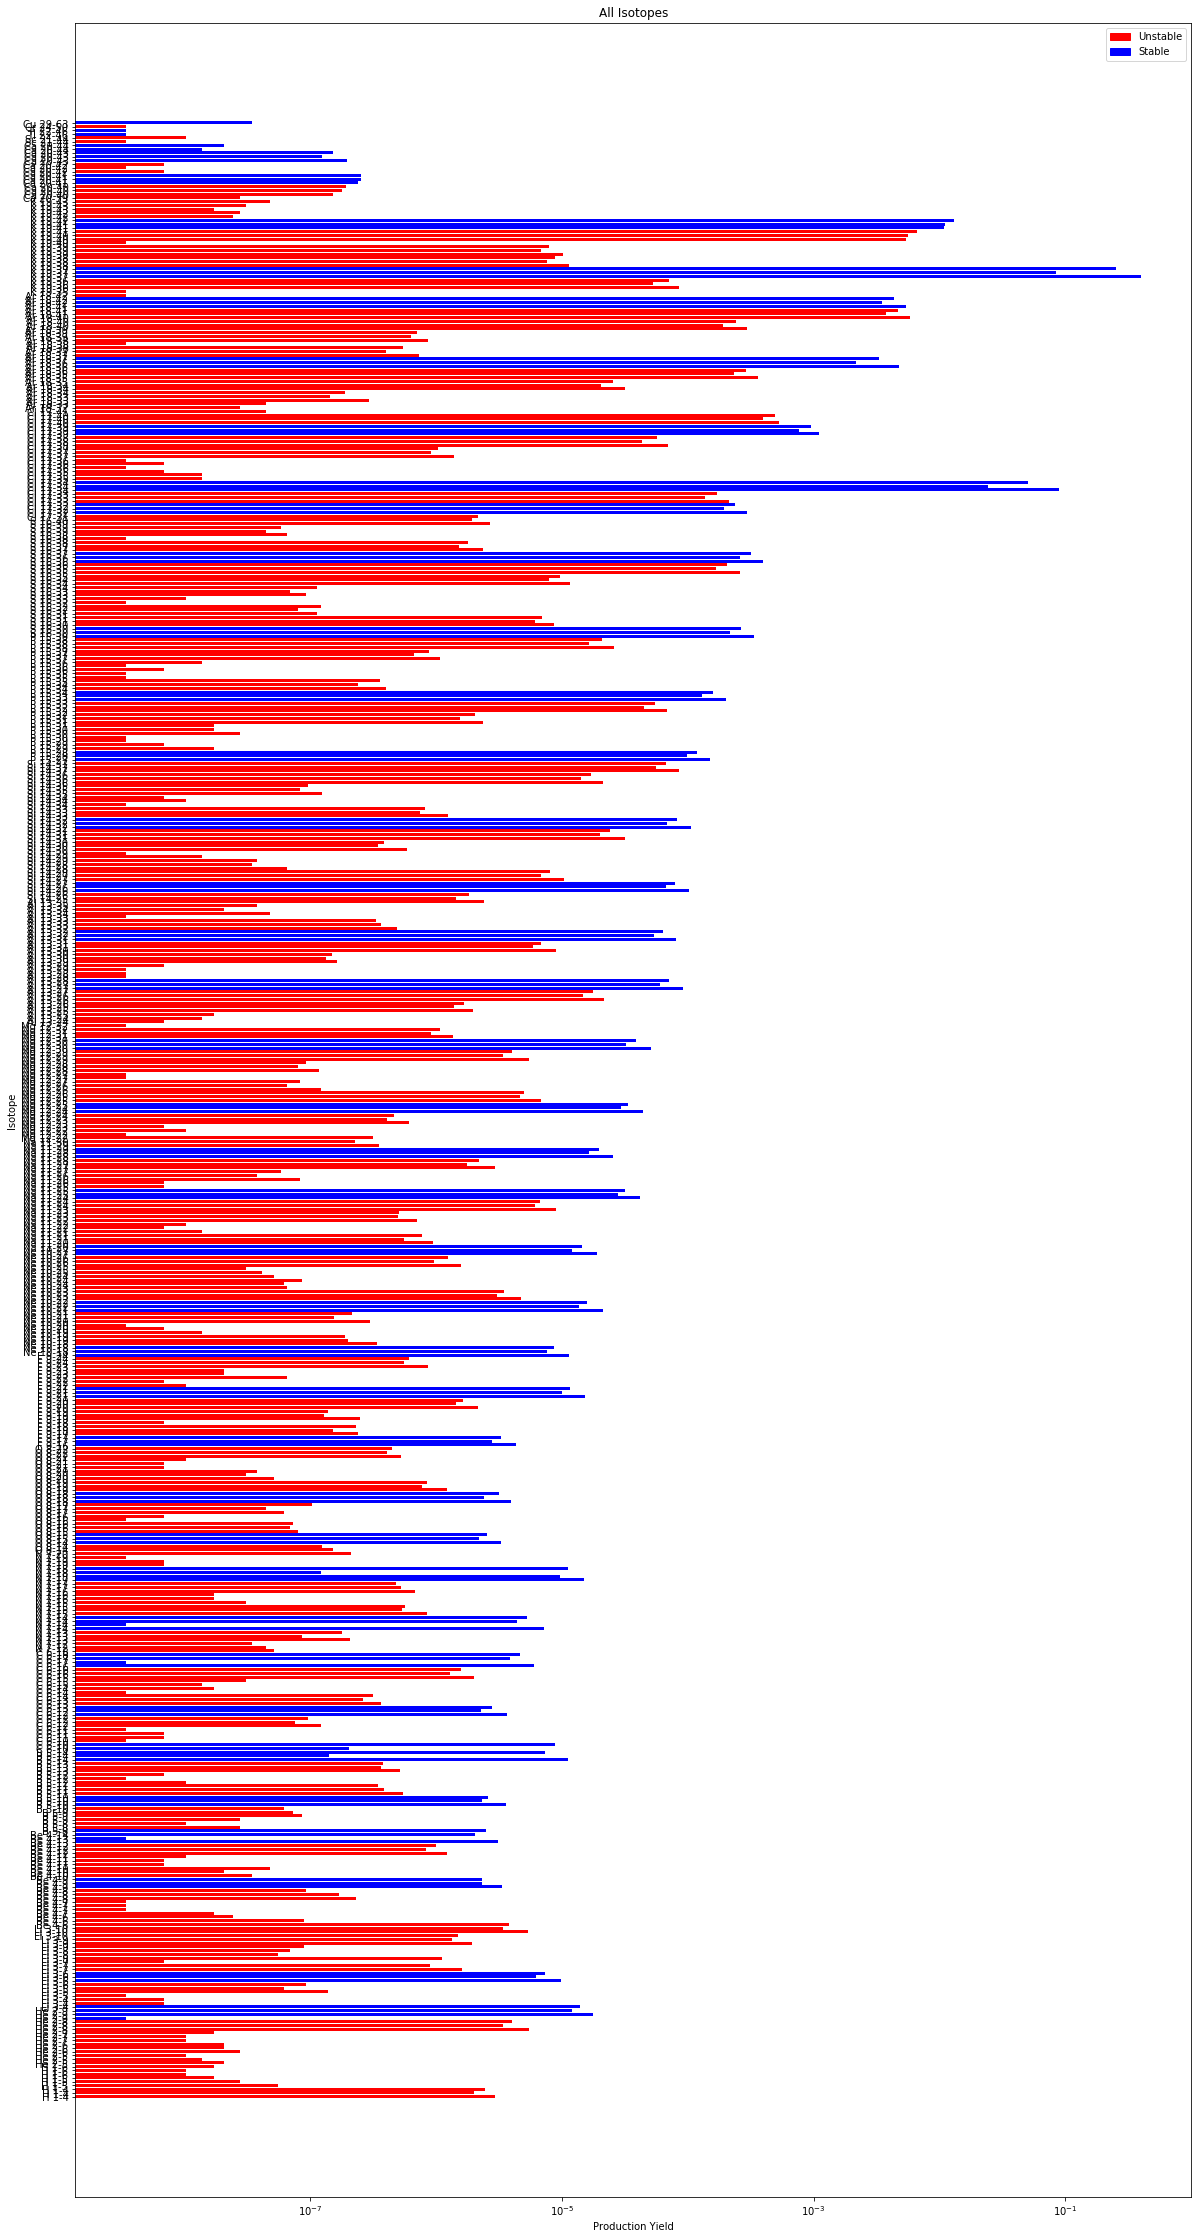

In [9]:
# Plot total
figsize=(20,40)
# Plotting
fig, ax = plt.subplots(figsize=figsize)
ax.barh(df.index, df["Production Yield"], log=True, color=df["Plot Colour"])
ax.set_yticklabels(df["Iso Symbol"])
ax.set_yticks(np.arange(len(df)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax.set_title("All Isotopes")
red_patch = mpatches.Patch(color="red", label="Unstable")
blue_patch = mpatches.Patch(color="blue", label="Stable")
ax.legend(handles=[red_patch, blue_patch], loc=0)
#plt.show()

# Plot unstable

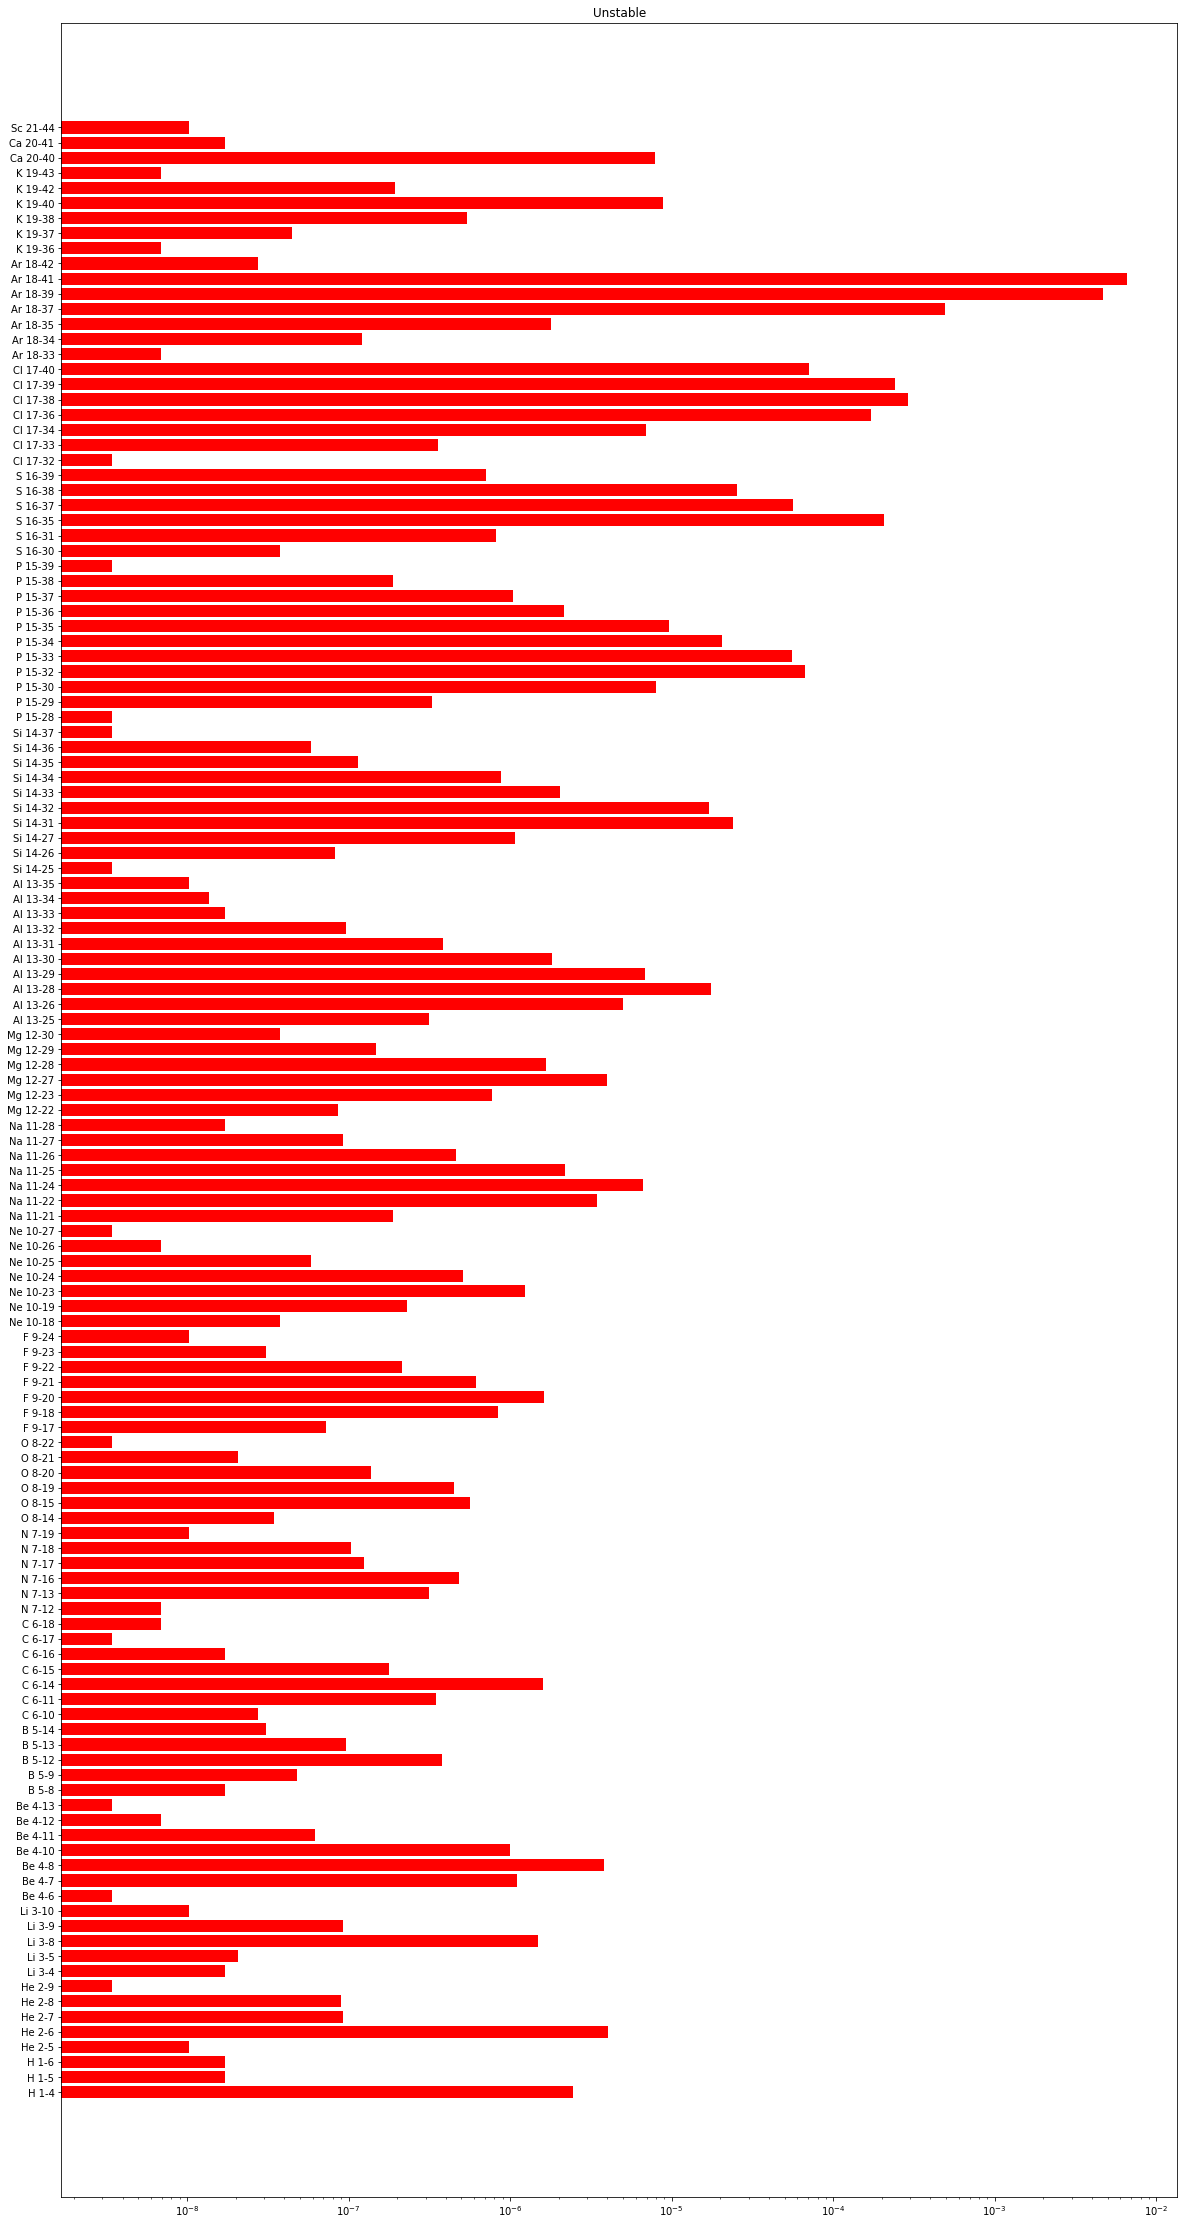

In [10]:
fig_un, ax_un = plt.subplots(figsize=figsize)
df_unstable_TPC = df_unstable[df_unstable["Detector Volume"] == 11].reset_index(drop=True)
ax_un.barh(df_unstable_TPC.index, df_unstable_TPC["Production Yield"], log=True, color=df_unstable_TPC["Plot Colour"])
ax_un.set_yticklabels(df_unstable_TPC["Iso Symbol"])
ax_un.set_yticks(np.arange(len(df_unstable_TPC)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_un.set_title("Unstable")
plt.show()

# Plot stable

Text(0.5, 1.0, 'Stable')

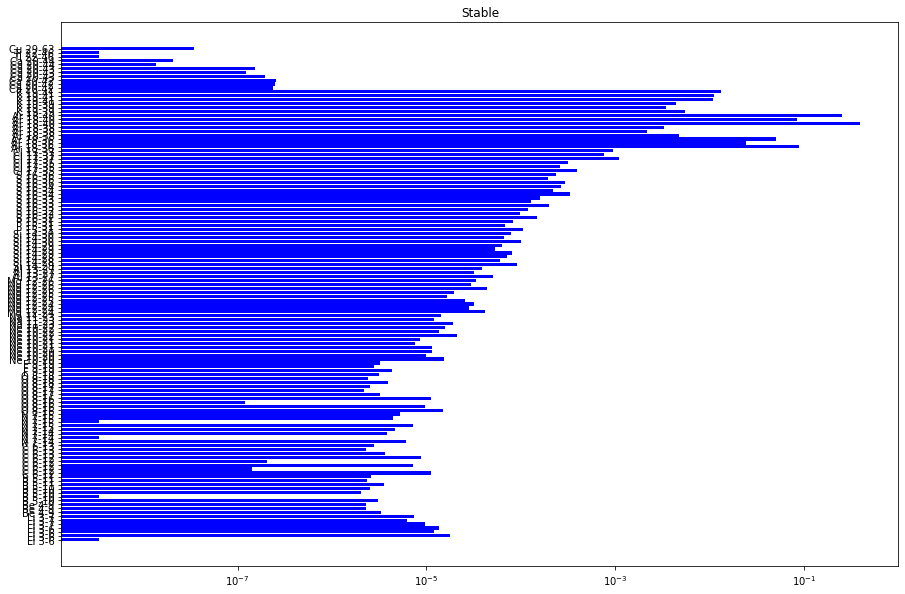

In [11]:
fig_s, ax_s = plt.subplots(figsize=(15,10))
ax_s.barh(df_stable.index, df_stable["Production Yield"], log=True, color=df_stable["Plot Colour"])
ax_s.set_yticklabels(df_stable["Iso Symbol"])
ax_s.set_yticks(np.arange(len(df_stable)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_s.set_title("Stable")
#plt.show()

# Ratio of counts in each volume
key: 7, 9, 11

val: Outer, Inner, TPC

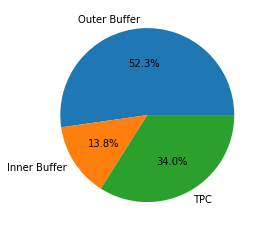

In [12]:
df_OB = df[df["Detector Volume"] == 7]
df_IB = df[df["Detector Volume"] == 9]
df_TPC = df[df["Detector Volume"] == 11]
plt.pie(x=[df_OB["Counts"].sum(), df_IB["Counts"].sum(), df_TPC["Counts"].sum()], autopct='%1.1f%%', labels=["Outer Buffer", "Inner Buffer", "TPC"])
plt.savefig('./img/volume-ratio.png')
plt.show()

# Looking for excess yields

In [13]:
# Sort df by counts
df_count_sort = df.sort_values(["Counts"], ascending=False)
# Try to highlight mass numbers > 40
# df_count_sort.style.apply(lambda x: ["background-color: red" if x["Mass Number"] > 40 else ""], axis = 1)
# Total df
df_count_sort.head(60)

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
486,Ar 18-40,18,40,114943991,7,0.396021,True,inf,None,NaN,blue,3.96222e+06,1
488,Ar 18-40,18,40,73513413,11,0.253279,True,inf,None,NaN,blue,2.53407e+06,0.639559
429,Ar 18-36,18,36,25779517,7,0.088819,True,inf,None,NaN,blue,888642,0.224279
487,Ar 18-40,18,40,24342254,9,0.083867,True,inf,None,NaN,blue,839099,0.211775
431,Ar 18-36,18,36,14500233,11,0.049958,True,inf,None,NaN,blue,499836,0.12615
430,Ar 18-36,18,36,7023578,9,0.024199,True,inf,None,NaN,blue,242109,0.0611043
501,K 19-41,19,41,3793765,11,0.013071,True,inf,None,NaN,blue,130774,0.0330053
500,K 19-41,19,41,3227401,9,0.011119,True,inf,None,NaN,blue,111251,0.028078
499,K 19-41,19,41,3139455,7,0.010816,True,inf,None,NaN,blue,108220,0.0273129
498,Ar 18-41,18,41,1904199,11,0.006561,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,65639.4,0.0165663


### Unstable (Counts)
To get a sense of most produced isotopes

In [14]:
# Unstable df sorted by counts
df_count_sort[df_count_sort["Stable"] == False].head(60)

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
498,Ar 18-41,18,41,1904199,11,0.006561,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,65639.4,0.0165663
475,Ar 18-39,18,39,1695066,7,0.005840,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,58430.4,0.0147469
497,Ar 18-41,18,41,1619848,9,0.005581,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,55837.6,0.0140925
496,Ar 18-41,18,41,1575590,7,0.005428,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,54312,0.0137075
477,Ar 18-39,18,39,1365362,11,0.004704,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,47065.2,0.0118785
476,Ar 18-39,18,39,1086982,9,0.003745,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,37469.2,0.00945661
447,Ar 18-37,18,37,154841,7,0.000533,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,5337.5,0.00134709
449,Ar 18-37,18,37,142467,11,0.000491,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,4910.96,0.00123944
448,Ar 18-37,18,37,115054,9,0.000396,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,3966.01,0.00100095
459,Cl 17-38,17,38,104823,7,0.000361,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,3613.34,0.00091194


### Unstable all (heavy (40>))
Any heavy isotopes that may decay

In [15]:
df_unstable[df_unstable["Detector Volume"] == 11].sort_values("Mass Number", ascending=False).head(20)

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
400,523,Sc 21-44,21,44,3,11,1.033602e-08,False,1.430000e+04,"[[EC, 1.0, 3.652]]",3.652,red,0.103413,1.73998e-08
391,516,K 19-43,19,43,2,11,6.890679e-09,False,8.030000e+04,"[[B-, 1.0, 1.815]]",1.815,red,0.0689417,8.69989e-09
388,510,K 19-42,19,42,56,11,1.929390e-07,False,4.440000e+04,"[[B-, 1.0, 3.526]]",3.526,red,1.93037,4.78494e-07
372,507,Ar 18-42,18,42,8,11,2.756272e-08,False,1.040000e+09,"[[B-, 1.0, 0.599]]",0.599,red,0.275767,6.08992e-08
398,504,Ca 20-41,20,41,5,11,1.722670e-08,False,3.220000e+12,"[[EC, 1.0, 0.421]]",0.421,red,0.172354,3.47996e-08
369,498,Ar 18-41,18,41,1904199,11,6.560612e-03,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,65639.4,0.0165663
395,494,Ca 20-40,20,40,2303,11,7.934617e-06,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,79.3864,2.00271e-05
385,491,K 19-40,19,40,2575,11,8.871749e-06,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red,88.7625,2.23935e-05
349,485,Cl 17-40,17,40,20529,11,7.072938e-05,False,8.100000e+01,"[[B-, 1.0, 7.482]]",7.482,red,707.653,0.000178591
366,477,Ar 18-39,18,39,1365362,11,4.704136e-03,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,47065.2,0.0118785


### Unstable all (Half-life)

In [16]:
df_unstable_sort_life = df_unstable.sort_values("Half Life (ns)", ascending=False)
df_unstable_sort_life.head(60)

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
395,494,Ca 20-40,20,40,2303,11,7.934617e-06,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,79.3864,2.00271e-05
393,492,Ca 20-40,20,40,2939,7,1.012585e-05,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,101.31,2.55603e-05
394,493,Ca 20-40,20,40,1962,9,6.759756e-06,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,67.6319,1.70605e-05
401,526,Cr 24-50,24,50,1,6,3.445340e-09,False,4.100000e+25,"[[2EC, None, 0.0]]",NaN,red,0.0344709,0
384,490,K 19-40,19,40,2212,9,7.621091e-06,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red,76.2496,1.92355e-05
385,491,K 19-40,19,40,2575,11,8.871749e-06,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red,88.7625,2.23935e-05
383,489,K 19-40,19,40,3277,7,1.129038e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red,112.961,2.85008e-05
49,65,Be 4-10,4,10,352,7,1.212760e-06,False,4.380000e+13,"[[B-, 1.0, 0.556]]",0.556,red,12.1337,3.05366e-06
50,66,Be 4-10,4,10,243,9,8.372175e-07,False,4.380000e+13,"[[B-, 1.0, 0.556]]",0.556,red,8.37642,2.10537e-06
51,67,Be 4-10,4,10,289,11,9.957031e-07,False,4.380000e+13,"[[B-, 1.0, 0.556]]",0.556,red,9.96208,2.50557e-06


# Looking at production yields

### Unstable (Production yield > 0.1%)

In [17]:
# Sets min production yield to be 1%
high_prod_yield = df_unstable[(df_unstable["Production Yield"] > 0.0001)]
high_prod_yield

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
315,407,S 16-35,16,35,75036,7,0.000259,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,2586.56,0.000652796
316,408,S 16-35,16,35,48395,9,0.000167,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,1668.22,0.000421022
317,409,S 16-35,16,35,59878,11,0.000206,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,2064.05,0.000520923
338,426,Cl 17-36,17,36,62018,7,0.000214,False,9.500000e+12,"[[B-, 0.981, 0.71], [EC, 0.019, 0.71]]",0.710,red,2137.81,0.000539541
339,427,Cl 17-36,17,36,39758,9,0.000137,False,9.500000e+12,"[[B-, 0.981, 0.71], [EC, 0.019, 0.71]]",0.710,red,1370.49,0.000345882
340,428,Cl 17-36,17,36,49549,11,0.000171,False,9.500000e+12,"[[B-, 0.981, 0.71], [EC, 0.019, 0.71]]",0.710,red,1708,0.000431062
341,459,Cl 17-38,17,38,104823,7,0.000361,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,3613.34,0.00091194
342,460,Cl 17-38,17,38,67509,9,0.000233,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,2327.09,0.000587312
343,461,Cl 17-38,17,38,83897,11,0.000289,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,2892,0.000729886
344,472,Cl 17-39,17,39,85930,7,0.000296,False,3.370000e+03,"[[B-, 1.0, 3.442]]",3.442,red,2962.08,0.000747573
